<div style="background-color:#104E8B; width:100%;"> <img src="http://23.236.50.13/wp-content/uploads/2016/04/white_logo.png" style="height:100px;padding:8px;" /></div>

## FORECASTING STOCK RETURNS WITH BIG DATA AND MACHINE LEARNING

### OVERVIEW:

**[LogitBot Inc.](http://www.logitbot.com)** uses machine learning and other advanced technologies to deliver investment insights and predictive analytics to investors across multiple time horizons. We combine massive amounts of data into a graph of the world's financial information and employ sophisticated models to uncover hidden relationships in order to understand and predict how markets are likely to behave. 


### SUMMARY

We are excited to demonstrate to the Quantopian community how they can our predicted stock return model outputs as a valuable signal in systematic strategies. The  predictions we are making available on Quantopian consider a large variety of predictors ranging from fundamental factors, historical returns to credit and interest rate spreads, commodity prices, fx fluctuations to forecast log returns at 5 day horizon.


### SAMPLE STRATEGY  
We have shared a trading strategy that utilizes the model forecasts to generate attractive returns. A 5 year backtest of the strategy on Quantopians platform results in: <br>
Total Returns  of **239.42%**, vs SPY **112.4%**<br>
Alpha: 0.33<br>
Beta: 0.18<br>
Sharpe: 3.20<br>
Sortino: 4.06<br>
 
** Complete details of the backtest and link to the algorithm are available [here:](https://www.quantopian.com/posts/logitbot-machine-learning-algorithm-demo)**. 

We have made a sample dataset with 1 year worth of data available  [here:](https://docs.google.com/spreadsheets/d/1YGx6t6tiEFBoeoNgdrHIgisCz_G0zzUxwBSNIfszfww/pub?gid=341396222&single=true&output=csv)


### BACKGROUND

### Time Series Prediciton 
Traditional methods of time-series analysis are mainly concerned with decomposing data into deterministic and non-deterministic components, namely:

**_1) Trend_** : The long-term change in the mean level, eg. an increasing trend.

**_2) Seasonal Effects_** : Many financial and macro economic time series such as earnings, commodity prices and home sales exhibit seasonal variations.

**_3) Noisy Residuals_**: The remaining component after trend and cyclic variations have been removed from a dataset. 

A large number of Linear and nonlinear statistical models have been proposed to predict time series. Examples include the Autoregressive model AR(n) and NARX which assume that the next value is a linear weighted sum of the past n values plus a random shock. A significant drawback of these models is that they interpret all the structure in a time series through linear correlation, which is rarely the case in real world applications. 


### Time Series Prediction as a Machine Learning Problem

An alternative to tradtional prediction methods, and LogitBot's preferred approach is to cast time series prediction as a supervised learning problem. In this context, learning algorirthms can be used to infer the complex, nonlinear relationships between the inputs and a desired output. 

Our learning procedure entails:

1) Choosing a family of candidate algorithms which give good approximations of the unknown function. <br>
2) Building and selecting the optimal set of features to use to train the candidate models. Machine learning algorithms are known to degrade in performance (prediction accuracy) when faced with many inputs.  Using all available features may negatively affect generalization performance, especially in the presence of irrelevant or redundant features.<br>
3) Selecting the model that best generalizes to previously unseen out-of-sample data 


### WALK THROUGH FOR A SINGLE SECURITY


We review the key steps we employ to build a predictive model using AAPL as an example

#### Import Libraries

In [6]:
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipline
import seaborn as sns


ImportError: No module named zipline

### ASSEMBLING TRAINING DATA 

Raw data includes descriptive information on the stock, historical end of day market data, various global benchmark indices, commoditiies prices, fx rates, economic data etc. It is  ill advised to use raw data in training models for reasons described below. 

In [5]:
ticker    = "AAPL"
input_csv = "stock_data_{} US EQUITY_20060101_20160527.csv".format(ticker)

input_df = pd.(input_csv, date_column = 'record_date',
                    use_date_column_as_index = True)


NameError: name 'load_csv' is not defined

In [52]:
input_df = input_df.drop(['bbg_ticker'], axis = 1)
input_df = input_df.rename(columns ={'yahoo_ticker':'ticker'})

In [53]:
input_df.iloc[-1].T

ticker                                  AAPL
company_name                       APPLE INC
open                                   99.44
high                                  100.47
low                                   99.245
close                                 100.35
volume                              36341240
dividend                                   0
split_ratio                                1
px_open                                99.44
px_high                               100.47
px_low                                99.245
px_close                              100.35
px_volume                           36341240
iso_country_code                         USA
exch_region                    NORTH AMERICA
sector                            TECHNOLOGY
industry                            HARDWARE
sub_industry        COMMUNICATIONS EQUIPMENT
sec_type                        COMMON STOCK
BDIY                                     606
DAX                                 10272.71
NKY       

Filter on the numerical data for correlation plots

In [54]:
numeric_df = input_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])


### THE PROBLEM WITH USING RAW INPUTS TO TRAIN MODELS 

<font color=#FF2400> **The Heatmap and distribution plots below indicate that many of the raw inputs are highly correlated and would NOT be useful in a machine learning algorithm. Many machine learning algorithms are known to degrade in performance when faced with highly correlated input features.**</font>

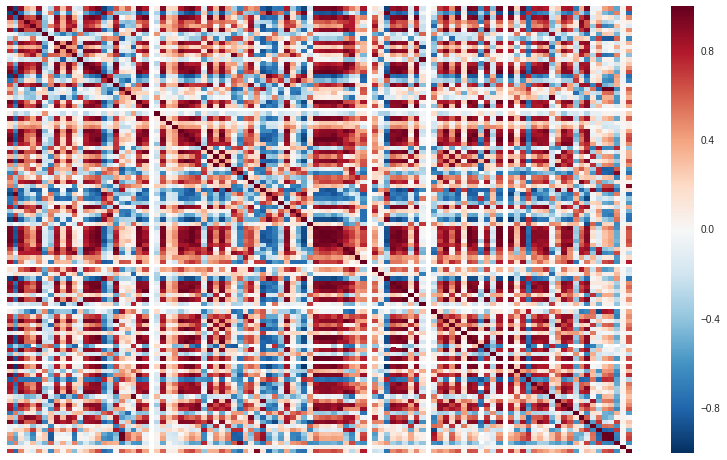

In [55]:
sns.heatmap(numeric_df.sample(frac = 1, axis = 1).corr(), xticklabels=False, yticklabels=False)

#### Distribution of pairwise correlations in sample raw data 

In [56]:
corr_df = numeric_df.corr()
s = corr_df.unstack()
corr_pairs = s.order(kind="quicksort")
corr_pairs = corr_pairs.drop_duplicates()
corr_pairs = corr_pairs.dropna(axis = 0)
corr_pairs = corr_pairs[corr_pairs<1]

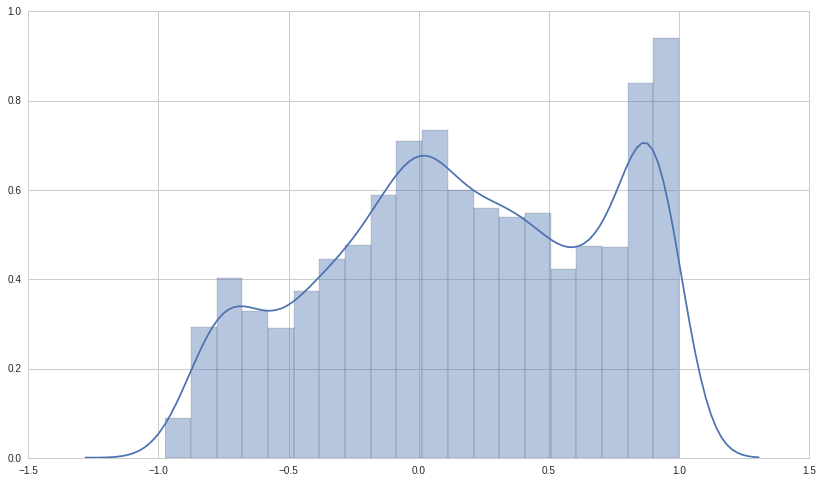

In [57]:
sns.distplot(corr_pairs)

### OUR SOLUTION TO HIGHLY CORRELATED RAW INPUTS - FEATURE ENGINEERING

The goal of feature engineering is to find a set of predictors that maximize the amount of useful information going  into model training while avoiding overfitting. Selecting good features creates simpler models that generalize well to different scenarios. LogitBot carefully constructs a large range of features which are relatively uncorrelated to train our models.

In [90]:
feat_df_csv = "training_data-training_feats-v1_2-{} US EQUITY_feat_data_20060101_20160527.csv".format(ticker)

feat_df = local_csv(feat_df_csv, date_column = 'record_date',
                    use_date_column_as_index = True, delimiter = '|')


#### Distribution of pairwise correlations in engineered features

<font color=#008080> **_The features features we use in model train have significantly less correlation and contain a broader set of useful information for model training_**</font>

In [59]:
feat_corr_df    = feat_df.corr()
s               = feat_corr_df.unstack()
feat_corr_pairs = s.order(kind="quicksort")
feat_corr_pairs = feat_corr_pairs.drop_duplicates()
feat_corr_pairs = feat_corr_pairs.dropna(axis = 0)
feat_corr_pairs = feat_corr_pairs[feat_corr_pairs<1]

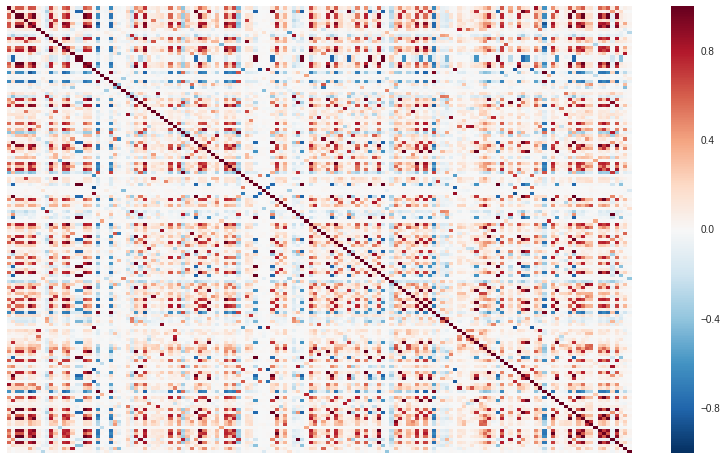

In [60]:
sample_corr = feat_df.sample(frac = 1, axis = 1).corr()
sns.heatmap(sample_corr, xticklabels=False, yticklabels=False)


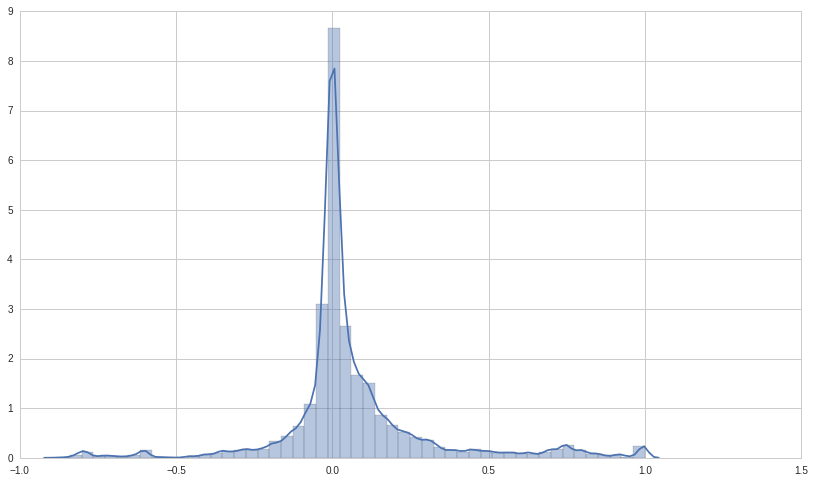

In [61]:
sns.distplot(feat_corr_pairs)

### TRAINING THE MODEL 

Model training is an iterative and compute intensive process. The process involves choosing:<br>
1) the ideal family of learners for the problem (e.g. neural networks, support vector machines,regression trees)<br>
2) Selecting the best values of hyper parameters (e.g. number of hidden layers, number of hidden nodes in NN, number of neighbors in KNN, number oflevels in trees)<br>
3) Wether to combine several unbiased models into a hyrbid predictor<br>

The final outcome is typically the result of a compromise between different factors, like the quantitative measures, the personal experience of the designer and the effort required to implement a particular model in practice

### A LOOK AT THE PREDICTIONS

Once a model is trained, it is useful to see how well it does at predicting the target. Numerous methods exist to 
evaluate the accuracy of models including mean square errror, mean absolute error, etc.  Depending on the strategy
the absolute error measure may not be as important as the model's ability to predict the direction or sign of
future returns

In [62]:
pred_csv = "{}_predictions_20060101_20160527.csv".format(ticker)

pred_df = local_csv(pred_csv, date_column = 'date',
                    use_date_column_as_index = True)

pred_df = pred_df.rename(columns={'model_h':'model_prediction'})

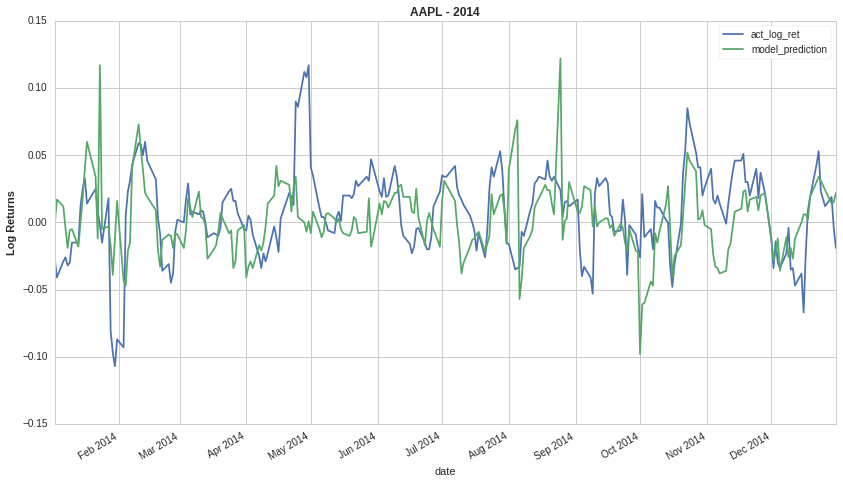

In [89]:
yr = 2014 # change yr to see different periods
plot_df = pred_df[pred_df.index.year==yr]
plot_df[['act_log_ret', 'model_prediction']].plot()
plt.title('{} - {}'.format(ticker, yr), weight = 'bold')
plt.ylabel('Log Returns', weight = 'bold')


### PUTTING IT ALL TOGETHER IN A SIMPLE STRATEGY
#### Strategy Summary
1) Trade Universe: 80 US Large Cap Stocks <br>
2) Trade Rules:  
a) Open long position if forecasted 5 day return is above average<br>
b) Enter long position if forecasted 5 day return is below average<br>
c) Hold positions for at least 3 days<br>

#### Strategy Backtest Results

In [2]:
bt= get_backtest('5759d71edeb8630f86aadca1') 

100% Time: 0:01:09|###########################################################|


Entire data start date: 2010-01-04
Entire data end date: 2016-05-31


Backtest Months: 76
                   Backtest
annual_return          0.18
annual_volatility      0.11
sharpe_ratio           1.59
calmar_ratio           1.61
stability              0.90
max_drawdown          -0.11
omega_ratio            1.37
sortino_ratio          2.44
skewness               0.20
kurtosis              11.23
information_ratio      0.02
alpha                  0.15
beta                   0.23

Worst Drawdown Periods
   net drawdown in %  peak date valley date recovery date duration
2              11.48 2011-09-07  2011-10-07    2011-11-30       61
1              10.87 2012-05-29  2012-11-15    2013-04-10      227
3               9.98 2013-04-11  2013-08-27    2014-08-18      353
0               9.43 2015-07-30  2015-09-09    2015-10-23       62
4               8.57 2011-08-10  2011-08-19    2011-09-07       21


2-sigma returns daily    -0.013
2-sigma returns weekly   -0.026
dtype: float64


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


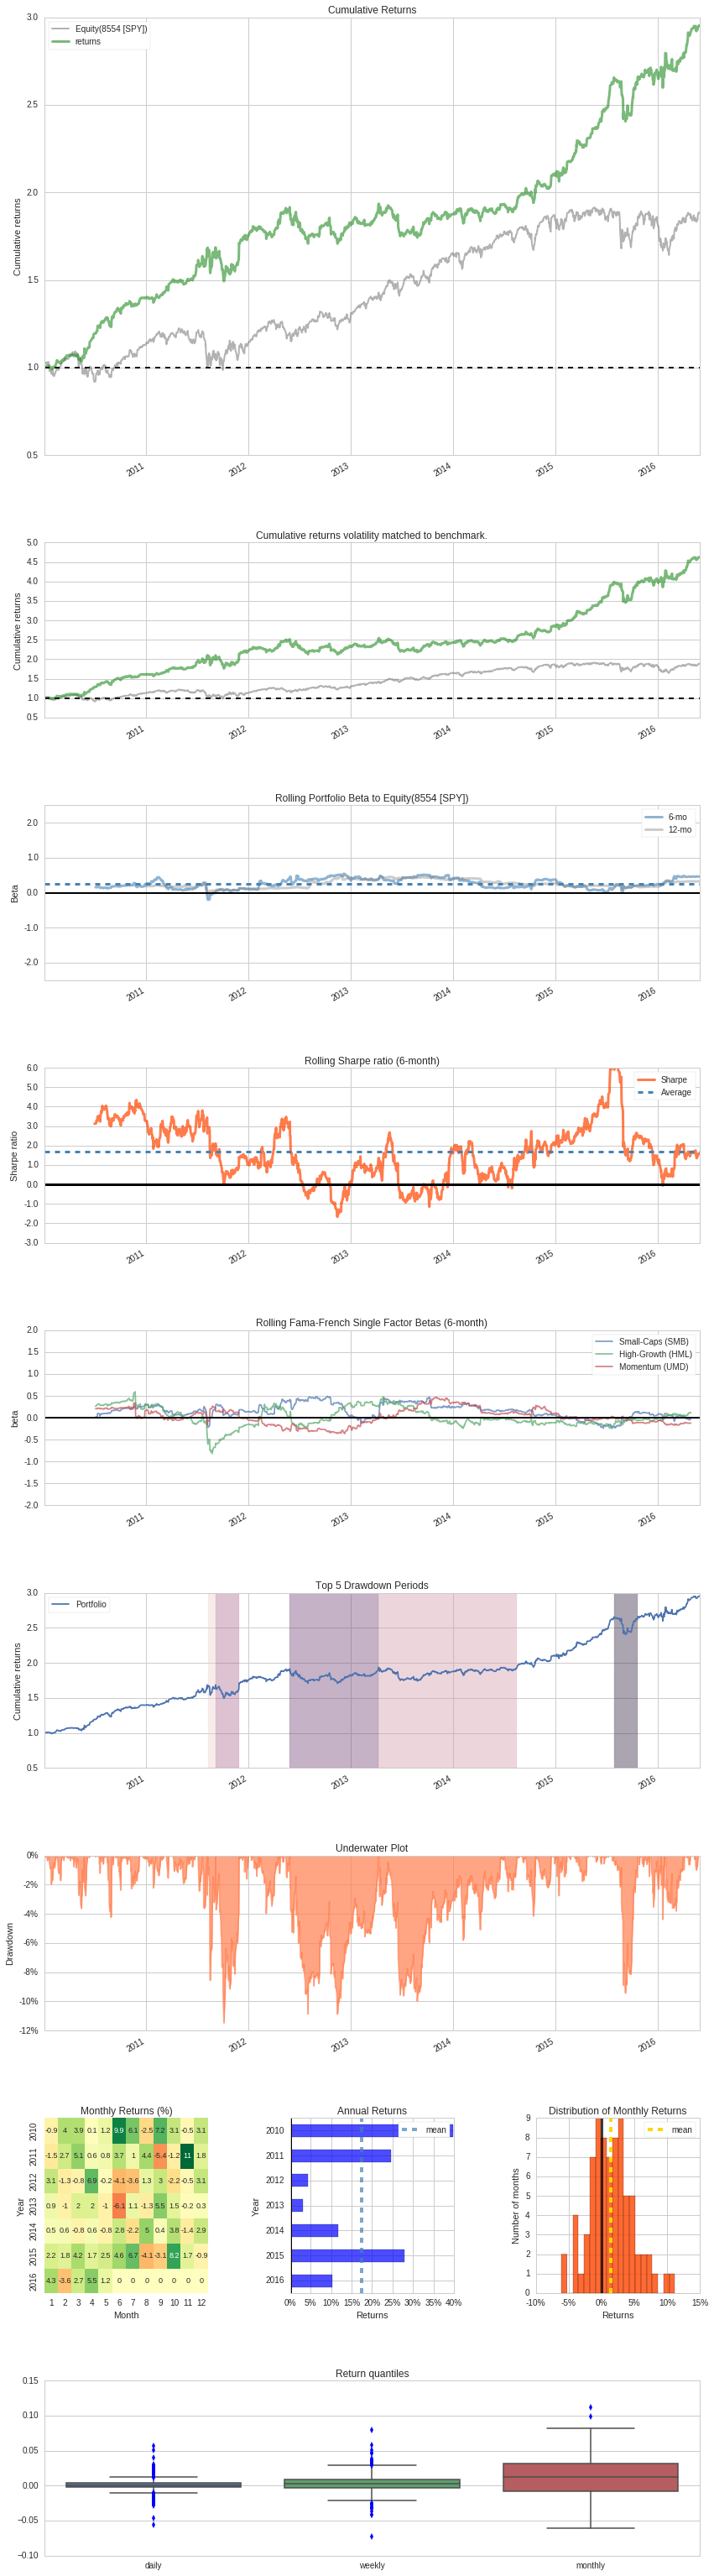


Stress Events
                                    mean    min    max
US downgrade/European Debt Crisis  0.001 -0.056  0.040
Fukushima                          0.002 -0.007  0.016
EZB IR Event                       0.001 -0.006  0.024
Flash Crash                       -0.004 -0.013  0.008
Apr14                              0.000 -0.009  0.010
Oct14                              0.002 -0.011  0.025
Fall2015                          -0.002 -0.046  0.016
Recovery                           0.001 -0.056  0.057
New Normal                         0.001 -0.046  0.028


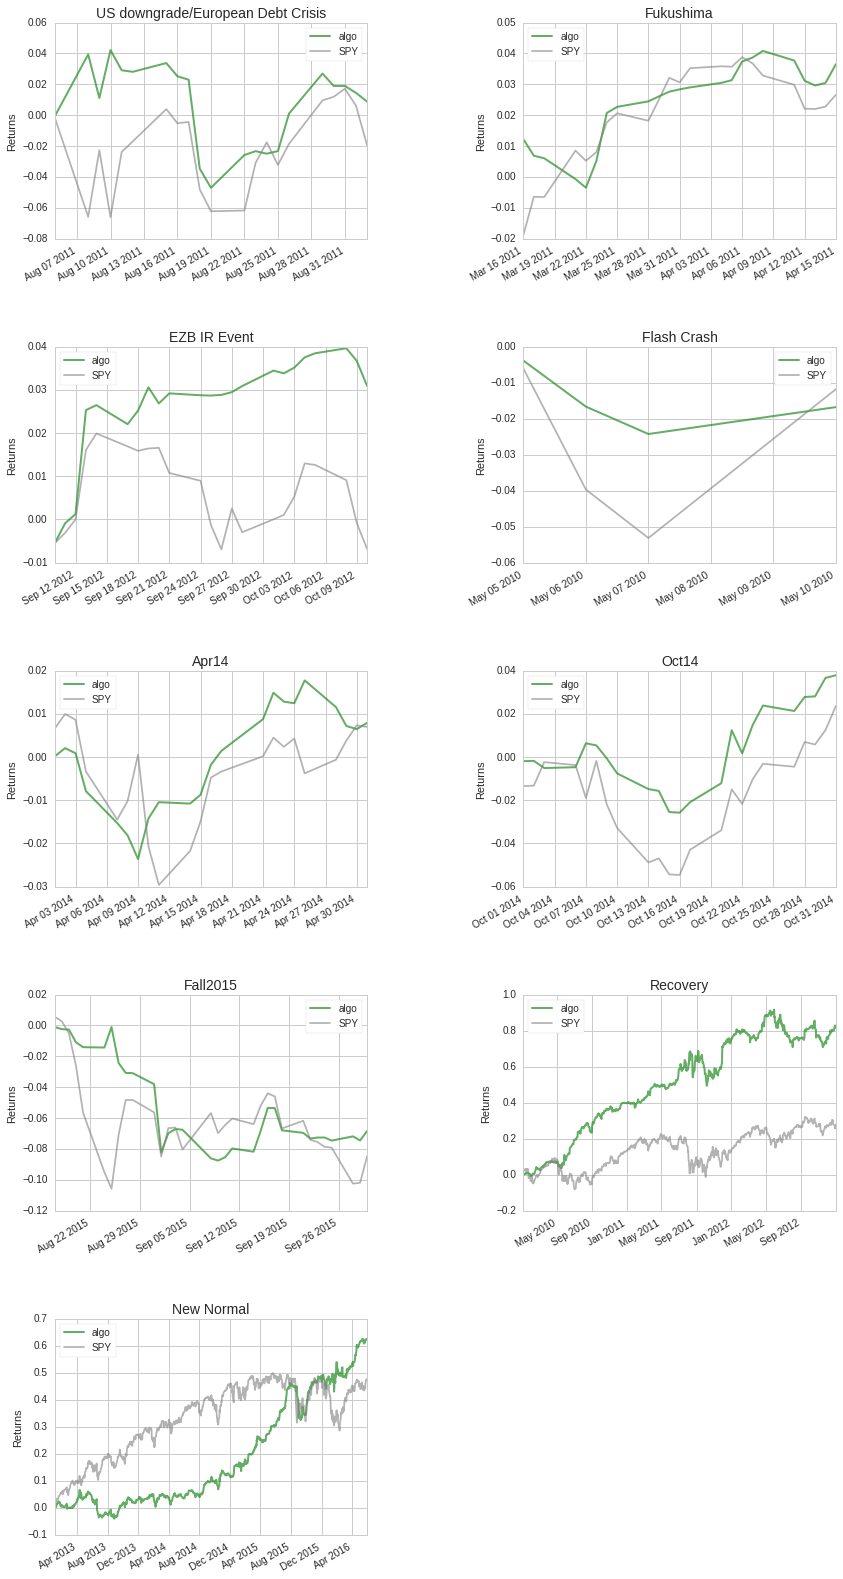



Top 10 long positions of all time (and max%)
[u'MA-32146' u'RY-13732' u'ABBV-43694' u'CELG-1406' u'GOOG-46631'
 u'AMZN-16841' u'BUD-38554' u'DIS-2190' u'INTC-3951' u'BAC-700']
[ 0.051  0.044  0.038  0.037  0.037  0.036  0.035  0.035  0.035  0.035]


Top 10 short positions of all time (and max%)
[u'TM-7543' u'MA-32146' u'C-1335' u'BAC-700' u'JPM-25006' u'RY-13732'
 u'TOT-7538' u'GILD-3212' u'MTU-22613' u'BUD-38554']
[-0.022 -0.018 -0.018 -0.018 -0.018 -0.018 -0.018 -0.018 -0.017 -0.017]


Top 10 positions of all time (and max%)
[u'MA-32146' u'RY-13732' u'ABBV-43694' u'CELG-1406' u'GOOG-46631'
 u'AMZN-16841' u'BUD-38554' u'DIS-2190' u'INTC-3951' u'BAC-700']
[ 0.051  0.044  0.038  0.037  0.037  0.036  0.035  0.035  0.035  0.035]


All positions ever held
[u'MA-32146' u'RY-13732' u'ABBV-43694' u'CELG-1406' u'GOOG-46631'
 u'AMZN-16841' u'BUD-38554' u'DIS-2190' u'INTC-3951' u'BAC-700' u'AGN-8572'
 u'MTU-22613' u'AZN-19954' u'TSM-17773' u'BMY-980' u'MO-4954' u'DCM-25377'
 u'C-1335' u'TOT-75

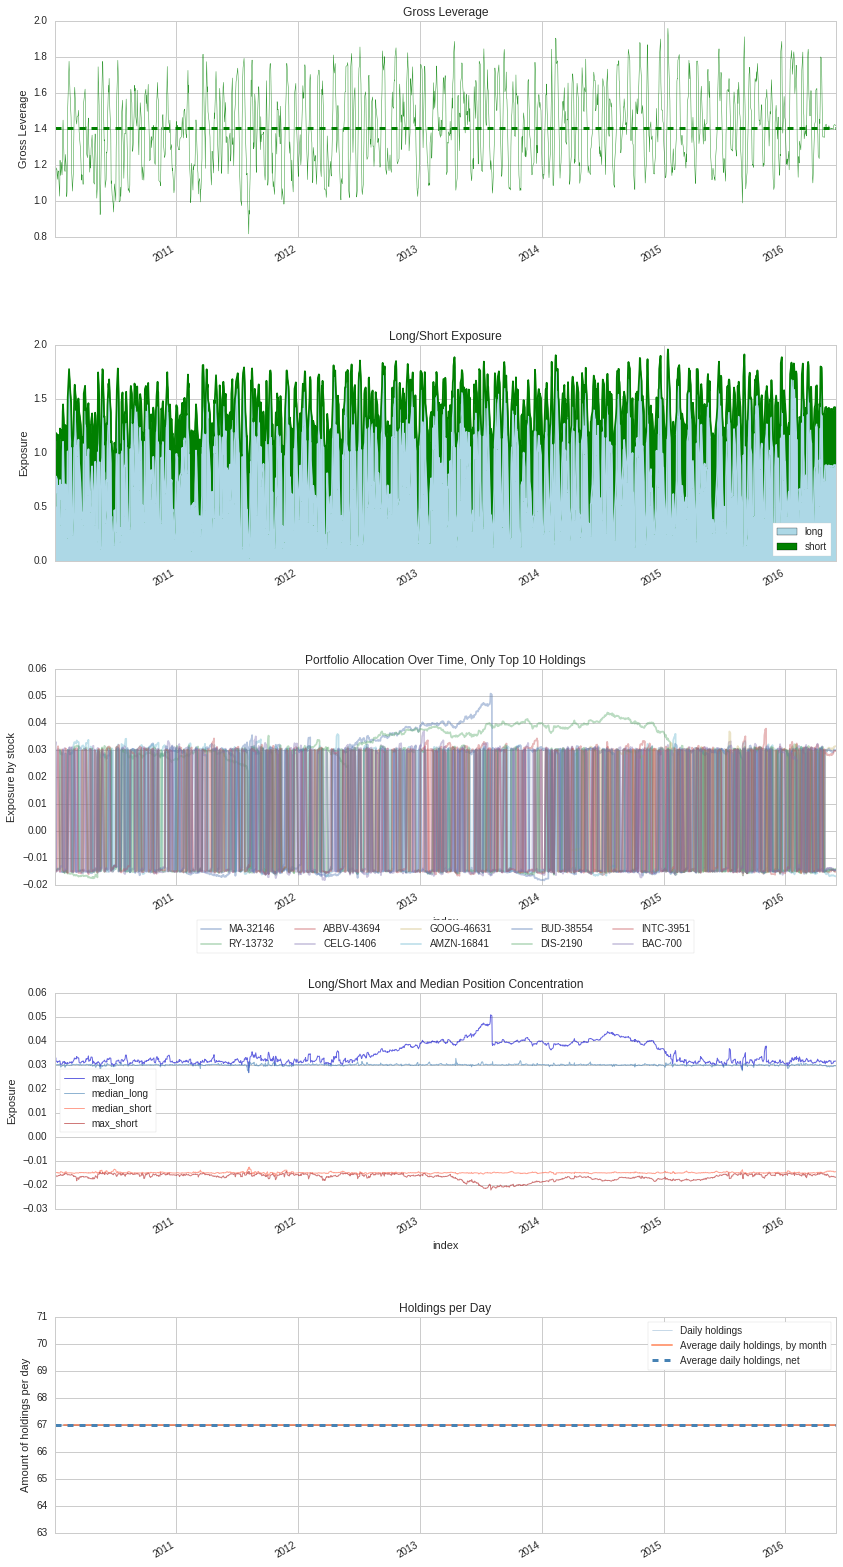

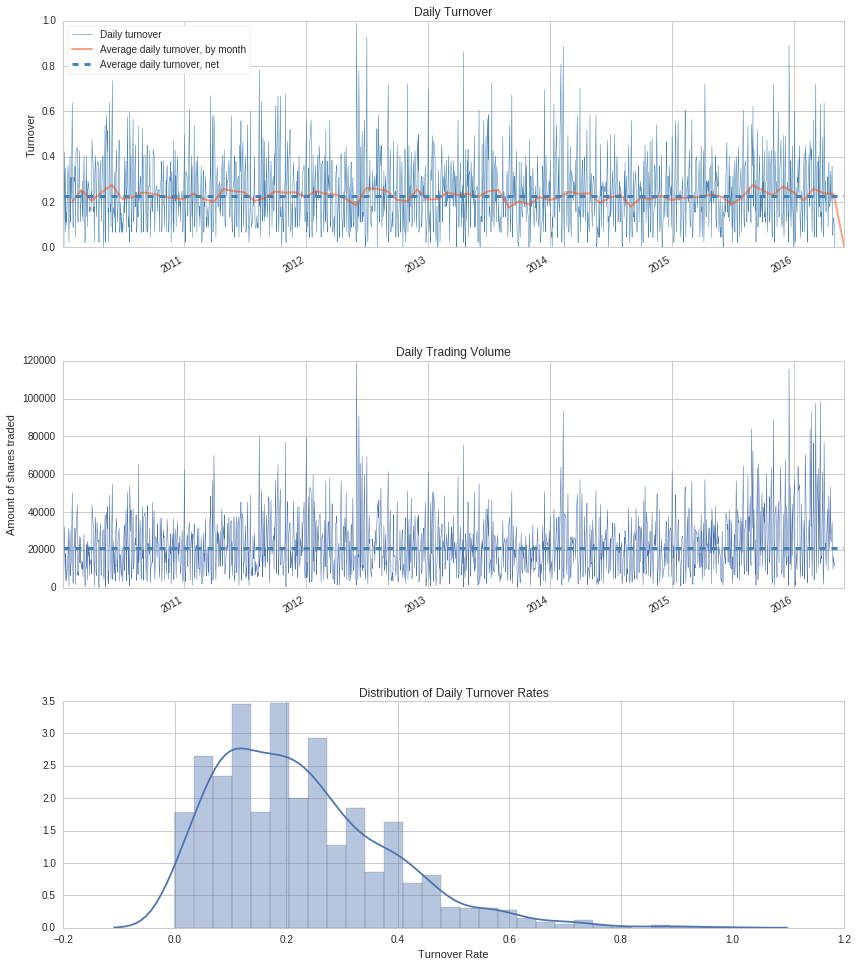

In [3]:
bt.create_full_tear_sheet()